In [ ]:
%matplotlib inline

In [ ]:
%matplotlib qt

###############################################################################################################################################

In [ ]:
# Per-Digit Alignment Using Template Matching

import os
import json
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_msssim import ssim
import torch.nn.functional as F
import mlflow
import mlflow.pytorch
from PIL import Image

# Target alpha and beta values
target_alpha = 88
target_beta = 2

# Directory containing metadata files and images
data_dir = "data_test"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the MLflow experiment and load the model
mlflow.set_experiment('Unet_Final')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet_Final')

runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    order_by=["attributes.start_time DESC"],
    max_results=1
)
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval()
model.to(device)
print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")

# Define PSNR calculation
def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

# Transform to convert PIL image to tensor in [0,1]
to_tensor = transforms.ToTensor()

# Scan metadata files
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]
found_file = None

# Find matching alpha and beta
for meta_file in metadata_files:
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)
    if metadata.get('alpha') == target_alpha and metadata.get('beta') == target_beta:
        found_file = {
            "metadata_file": meta_file,
            "index": metadata.get('idx'),
            "noise_level": metadata.get('noise_level'),
            "digit_bboxes": metadata.get('digit_bboxes'),
            "plate_number": metadata.get('plate_number')
        }
        break

print(f"Found metadata file: {found_file['metadata_file']}")
print(f"Alpha: {target_alpha}, Beta: {target_beta}")
print(f"Noise Level: {found_file['noise_level']:.2f}")
print(f"Plate Number: {found_file['plate_number']}")

# Sort bounding boxes
original_bboxes = sorted(found_file['digit_bboxes'], key=lambda bbox: bbox[0])

# Load images
original_image_path = os.path.join(data_dir, f"original_{found_file['index']}.png")
distorted_image_path = os.path.join(data_dir, f"distorted_{found_file['index']}.png")

original_img = to_tensor(Image.open(original_image_path).convert('RGB')).unsqueeze(0).to(device)
distorted_img = to_tensor(Image.open(distorted_image_path).convert('RGB')).unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_tensor = model(distorted_img)
    reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

# Convert to NumPy
original_np = original_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed_np = reconstructed_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Align and update bounding boxes for the reconstructed image
def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    search_margin = 10

    for bbox in digit_bboxes:
        x, y, w, h = bbox

        # Extract original digit
        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Define search window
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Template matching
        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1

        updated_bboxes.append((best_x, best_y, w, h))

        # Extract aligned digit
        aligned_digit = reconstructed_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)

        # Compute metrics
        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

# Perform alignment
psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, original_bboxes)

# Visualization
reconstructed_show = (reconstructed_np * 255).astype(np.uint8)
reconstructed_show = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)
original_image_cv = cv2.imread(original_image_path)

# Draw original bounding boxes
for i, bbox in enumerate(original_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(original_image_cv, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

# Draw updated bounding boxes on reconstructed image
for i, bbox in enumerate(updated_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(reconstructed_show, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(reconstructed_show, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
reconstructed_image_rgb = cv2.cvtColor(reconstructed_show, cv2.COLOR_BGR2RGB)

# Prepare table
table_data = [["Digit", "PSNR(dB)", "SSIM"]]
for i, (psnr_val, ssim_val) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
    table_data.append([str(i), f"{psnr_val:.2f}", f"{ssim_val:.3f}"])
transposed_table_data = list(zip(*table_data))

# Plotting
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(reconstructed_image_rgb)
plt.title('Reconstructed Image')
plt.axis('off')

table = plt.table(cellText=transposed_table_data,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, -0.55, 1, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.tight_layout()
plt.show()


###############################################################################################################################################

In [ ]:
# Best PSNR Selection with Template Matching

import os
import json
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import mlflow
import mlflow.pytorch
import sys
import cv2
from pytorch_msssim import ssim

# -----------------------------------
# Configuration
# -----------------------------------
data_dir = "data_test"
moderate_noise_threshold = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------------
# Load Model
# -----------------------------------
mlflow.set_experiment('Unet_Final')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet_Final')
runs = client.search_runs(experiment_ids=experiment.experiment_id, order_by=["attributes.start_time DESC"])
run_id = runs[0].info.run_id  # Get the last run
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval()
model.to(device)
print(f"Model loaded from run {run_id} in experiment {experiment.name}")

def calculate_psnr(outputs, targets):
    """Calculate PSNR between two [0,1] tensor images using PyTorch functions."""
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

to_tensor = transforms.ToTensor()

# Function to align and update bboxes using template matching per digit
def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    search_margin = 10

    for bbox in digit_bboxes:
        x, y, w, h = bbox

        # Extract original digit
        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Define search window in reconstructed image
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Template matching
        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1

        updated_bboxes.append((best_x, best_y, w, h))

        # Extract aligned digit
        aligned_digit = reconstructed_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2,0,1)).unsqueeze(0).to(device)

        # Compute metrics
        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

# -----------------------------------
# Compute PSNR Heatmap
# -----------------------------------
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]

psnr_dict_avg = {}
psnr_dict_worst = {}

for meta_file in tqdm(metadata_files, desc="Processing images", unit="image"):
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)

    alpha, beta, noise_level = metadata['alpha'], metadata['beta'], metadata['noise_level']
    digit_bboxes = metadata['digit_bboxes']

    idx = metadata['idx']
    original_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{idx}.png")

    # Load images as tensors
    original_img = to_tensor(Image.open(original_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_path).convert('RGB')).unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed_img = model(distorted_img)
        reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

    # Convert images to NumPy
    original_np = original_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    reconstructed_np = reconstructed_img.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Apply template matching alignment per digit
    psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes)
    avg_psnr = np.mean(psnr_per_number) if psnr_per_number else 0
    worst_psnr = min(psnr_per_number, default=0)

    if (alpha, beta) not in psnr_dict_avg:
        psnr_dict_avg[(alpha, beta)] = []
        psnr_dict_worst[(alpha, beta)] = []
    psnr_dict_avg[(alpha, beta)].append(avg_psnr)
    psnr_dict_worst[(alpha, beta)].append(worst_psnr)

# Average over multiple images if any
for key in psnr_dict_avg:
    psnr_dict_avg[key] = np.mean(psnr_dict_avg[key])
    psnr_dict_worst[key] = np.mean(psnr_dict_worst[key])

alpha_values = sorted(set(a for (a, b) in psnr_dict_avg.keys()))
beta_values = sorted(set(b for (a, b) in psnr_dict_avg.keys()))
num_alphas, num_betas = len(alpha_values), len(beta_values)

psnr_matrix_avg = np.full((num_betas, num_alphas), np.nan)
alpha_to_idx = {val: i for i, val in enumerate(alpha_values)}
beta_to_idx = {val: i for i, val in enumerate(beta_values)}

# Populate the PSNR matrix
for (a, b), val in psnr_dict_avg.items():
    psnr_matrix_avg[beta_to_idx[b], alpha_to_idx[a]] = val



In [ ]:
# Show image details for a given alpha,beta function

# -----------------------------------
# Function to show image details for a given alpha,beta
# Using the same template matching approach inside show_image_details_for
# -----------------------------------
def show_image_details_for(alpha, beta, data_dir, model, device):
    metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]
    found_file = None
    for meta_file in metadata_files:
        meta_path = os.path.join(data_dir, meta_file)
        with open(meta_path, 'r') as f:
            metadata = json.load(f)
        if metadata.get('alpha') == alpha and metadata.get('beta') == beta:
            found_file = {
                "metadata_file": meta_file,
                "index": metadata.get('idx'),
                "noise_level": metadata.get('noise_level'),
                "digit_bboxes": metadata.get('digit_bboxes'),
                "plate_number": metadata.get('plate_number')
            }
            break

    if found_file is None:
        print(f"No images found for alpha={alpha}, beta={beta}.")
        return

    found_file['digit_bboxes'].sort(key=lambda bbox: bbox[0])

    idx = found_file['index']
    original_image_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_image_path = os.path.join(data_dir, f"distorted_{idx}.png")

    to_tensor = transforms.ToTensor()
    original_img = to_tensor(Image.open(original_image_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_image_path).convert('RGB')).unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed_tensor = model(distorted_img)
        reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

    original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
    reconstructed_np = reconstructed_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    # Align and update bboxes with template matching
    def calc_psnr_ssim(original_image, reconstructed_image, digit_bboxes):
        # We'll reuse align_and_update_bboxes here to get aligned results
        psnr_vals, ssim_vals, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes)
        return psnr_vals, ssim_vals, updated_bboxes

    psnr_per_number, ssim_per_number, updated_bboxes = calc_psnr_ssim(original_img, reconstructed_tensor, found_file['digit_bboxes'])

    reconstructed_show = (reconstructed_np * 255).astype(np.uint8)
    reconstructed_show = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)
    original_image_cv = cv2.imread(original_image_path)

    for i, bbox in enumerate(found_file['digit_bboxes'], start=1):
        x, y, w, h = bbox
        cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0, 0, 255), 1)
        cv2.putText(original_image_cv, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

    for i, bbox in enumerate(updated_bboxes, start=1):
        x, y, w, h = bbox
        cv2.rectangle(reconstructed_show, (x, y), (x+w, y+h), (0, 0, 255), 1)
        cv2.putText(reconstructed_show, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

    original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
    reconstructed_image_rgb = cv2.cvtColor(reconstructed_show, cv2.COLOR_BGR2RGB)

    table_data = [["Digit", "PSNR(dB)", "SSIM"]]
    for i, (p, s) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
        table_data.append([str(i), f"{p:.2f}", f"{s:.3f}"])
    transposed_table_data = list(zip(*table_data))

    fig2 = plt.figure(figsize=(14, 7))
    plt.subplot(2, 1, 1)
    plt.imshow(original_image_rgb)
    plt.title(f'Original Image (Alpha={alpha}, Beta={beta})')
    plt.axis('off')

    plt.subplot(2, 1, 2)
    plt.imshow(reconstructed_image_rgb)
    plt.title('Reconstructed Image')
    plt.axis('off')

    table = plt.table(cellText=transposed_table_data,
                      cellLoc='center',
                      loc='center',
                      bbox=[0, -0.55, 1, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.tight_layout()
    plt.show()

# -----------------------------------
# Display Heatmap and Add Click Event
# -----------------------------------
plt.figure(figsize=(10, 8))
im = plt.imshow(psnr_matrix_avg, origin='lower', aspect='auto', cmap="viridis")
plt.title("Average PSNR per Digit")
plt.colorbar(label='PSNR (dB)')
plt.xticks(range(0, num_alphas, 5), alpha_values[::5])
plt.yticks(range(0, num_betas, 5), beta_values[::5])
plt.xlabel("Alpha (degrees)")
plt.ylabel("Beta (degrees)")

def format_coord(x, y):
    col = int(round(x))
    row = int(round(y))
    if 0 <= row < num_betas and 0 <= col < num_alphas:
        alpha = alpha_values[col]
        beta = beta_values[row]
        psnr_value = psnr_matrix_avg[row, col]
        return f"Alpha: {alpha:.0f}, Beta: {beta:.0f}, PSNR: {psnr_value:.2f} dB" if not np.isnan(psnr_value) else f"Alpha: {alpha:.0f}, Beta: {beta:.0f}, PSNR: N/A"
    return "Alpha: N/A, Beta: N/A"

plt.gca().format_coord = format_coord

def on_click(event):
    if event.inaxes == plt.gca():
        x, y = event.xdata, event.ydata
        if x is None or y is None:
            return
        col = int(round(x))
        row = int(round(y))
        if 0 <= row < num_betas and 0 <= col < num_alphas:
            alpha = alpha_values[col]
            beta = beta_values[row]
            show_image_details_for(alpha, beta, data_dir, model, device)

plt.gcf().canvas.mpl_connect('button_press_event', on_click)

plt.tight_layout()
plt.show()


###############################################################################################################################################

In [ ]:
# OCR with Global Template Matching and Bounding Box Alignment


import os
import json
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
import torch.nn.functional as F
import mlflow
import mlflow.pytorch
from paddleocr import PaddleOCR

# -----------------------------------------------------
# Configuration
# -----------------------------------------------------

data_dir = "data_test"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize PaddleOCR (English, digits only, low confidence allowed)
ocr = PaddleOCR(
    use_angle_cls=False,  
    lang='en',
    use_space_char=False,
    drop_score=0.1,
)

# -----------------------------------------------------
# Load Model via MLflow
# -----------------------------------------------------
mlflow.set_experiment('Unet_Final')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet_Final')
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    order_by=["attributes.start_time DESC"],
    max_results=1
)
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval()
model.to(device)
print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")

# -----------------------------------------------------
# Locate Metadata for Given Alpha, Beta
# -----------------------------------------------------
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]
found_file = None
for meta_file in metadata_files:
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)
    if metadata.get('alpha') == target_alpha and metadata.get('beta') == target_beta:
        found_file = {
            "metadata_file": meta_file,
            "index": metadata.get('idx'),
            "noise_level": metadata.get('noise_level'),
            "digit_bboxes": metadata.get('digit_bboxes'),
            "plate_number": metadata.get('plate_number')
        }
        break

if not found_file:
    print("No image found for given alpha, beta.")
    exit()

print(f"Found metadata file: {found_file['metadata_file']}")
print(f"Alpha: {target_alpha}, Beta: {target_beta}")
print(f"Noise Level: {found_file['noise_level']:.2f}")
print(f"Plate Number: {found_file['plate_number']}")

# Sort original bboxes by x to ensure left-to-right order
original_bboxes = sorted(found_file['digit_bboxes'], key=lambda bbox: bbox[0])

original_image_path = os.path.join(data_dir, f"original_{found_file['index']}.png")
distorted_image_path = os.path.join(data_dir, f"distorted_{found_file['index']}.png")

to_tensor = transforms.ToTensor()

original_img = to_tensor(Image.open(original_image_path).convert('RGB')).unsqueeze(0).to(device)
distorted_img = to_tensor(Image.open(distorted_image_path).convert('RGB')).unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_tensor = model(distorted_img)
    reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
reconstructed_np = reconstructed_tensor.squeeze(0).permute(1,2,0).cpu().numpy()


def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    """
    Template matching to find updated bounding boxes for each digit.
    """
    from pytorch_msssim import ssim
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    search_margin = 10

    for bbox in digit_bboxes:
        x, y, w, h = bbox

        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x = max_loc[0] + search_x1
        best_y = max_loc[1] + search_y1

        updated_bboxes.append((best_x, best_y, w, h))

        aligned_digit = reconstructed_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2,0,1)).unsqueeze(0).to(device)

        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, original_bboxes)

# -----------------------------------------------------
# Run PaddleOCR on the reconstructed image
# -----------------------------------------------------
reconstructed_show = (reconstructed_np * 255).astype(np.uint8)
reconstructed_show_bgr = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)

ocr_results = ocr.ocr(reconstructed_show_bgr, cls=False)

# -----------------------------------------------------
# Process OCR Results:
# Filter digits only, and align them with updated_bboxes
# -----------------------------------------------------
def extract_digits_from_ocr(ocr_results):
    """
    Extracts per-character bounding boxes for digits from PaddleOCR line results.
    If a line says "3163" with one bounding box, we split horizontally.
    Returns a list of dicts: {"char": c, "bbox": (x1,y1,x2,y2)} for each digit found.
    """
    per_char_results = []

    for line in ocr_results[0]:
        box, (text, conf) = line
        if not isinstance(text, str) or text.strip() == "":
            continue
        text = text.strip()

        # Keep only digits from this text
        filtered_text = "".join([ch for ch in text if ch.isdigit()])
        if len(filtered_text) == 0:
            continue

        xs = [p[0] for p in box]
        ys = [p[1] for p in box]
        min_x, max_x = min(xs), max(xs)
        min_y, max_y = min(ys), max(ys)

        num_chars = len(text)
        # We'll subdivide bounding box by number of characters to approximate char positions
        # But we only consider digits. This means we must map digits back to their positions
        # in the original text.

        # Approach: for each character in text, assign a sub-box. Then only keep if it's a digit.
        width = max_x - min_x
        char_width = width / num_chars if num_chars > 0 else width

        current_x = min_x
        for i, ch in enumerate(text):
            c_x1 = int(min_x + i * char_width)
            c_x2 = int(min_x + (i+1)* char_width)
            c_y1 = int(min_y)
            c_y2 = int(max_y)

            if ch.isdigit():
                per_char_results.append({
                    "char": ch,
                    "bbox": (c_x1, c_y1, c_x2, c_y2)
                })

    return per_char_results

char_results = []
if ocr_results and len(ocr_results) > 0 and ocr_results[0] is not None:
    char_results = extract_digits_from_ocr(ocr_results)

# Sort recognized digits by x-coordinate
char_results.sort(key=lambda r: r["bbox"][0])  # sort by left x

recognized_chars = [r["char"] for r in char_results]
recognized_text = "".join(recognized_chars)

# We know we need exactly 6 digits:
plate_number = found_file['plate_number']
assert len(plate_number) == 6, "Plate number must have exactly 6 digits"

# If we have more than 6 recognized digits, take only first 6 (leftmost)
if len(recognized_chars) > 6:
    recognized_chars = recognized_chars[:6]
    char_results = char_results[:6]

# If fewer than 6 digits recognized, fill missing with '?'
if len(recognized_chars) < 6:
    missing = 6 - len(recognized_chars)
    recognized_chars.extend(['?'] * missing)

final_recognized_text = "".join(recognized_chars[:6])

# Compute accuracy:
correct_digits = sum(1 for a, b in zip(plate_number, final_recognized_text) if a == b)
accuracy = correct_digits / 6.0

print(f"\nPlate Number (GT): {plate_number}")
print(f"Recognized (final): {final_recognized_text}")
print(f"OCR Accuracy: {accuracy * 100:.2f}%")

# -----------------------------------------------------
# Visualization
# -----------------------------------------------------
# Draw original bounding boxes on original image
original_image_cv = cv2.imread(original_image_path)
for i, bbox in enumerate(original_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(original_image_cv, str(i), (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

# Draw updated bounding boxes on reconstructed image
reconstructed_show_bgr = reconstructed_show_bgr.copy()
for i, bbox in enumerate(updated_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(reconstructed_show_bgr, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(reconstructed_show_bgr, str(i), (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

# Draw recognized characters on reconstructed image
for r in char_results:
    c = r["char"]
    x1, y1, x2, y2 = r["bbox"]
    cv2.rectangle(reconstructed_show_bgr, (x1,y1), (x2,y2), (0,255,0), 1)
    cv2.putText(reconstructed_show_bgr, c, (x1,y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0),1)

# Prepare table for PSNR, SSIM
table_data = [["Digit", "PSNR(dB)", "SSIM"]]
for i, (psnr_val, ssim_val) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
    table_data.append([str(i), f"{psnr_val:.2f}", f"{ssim_val:.3f}"])
transposed_table_data = list(zip(*table_data))

original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
reconstructed_image_rgb = cv2.cvtColor(reconstructed_show_bgr, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image with Original BBoxes')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(reconstructed_image_rgb)
plt.title(f"Reconstructed Image with Updated BBoxes and OCR Results\nRecognized: {final_recognized_text}, Accuracy: {accuracy*100:.2f}%")
plt.axis('off')

table = plt.table(cellText=transposed_table_data,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, -0.55, 1, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)

plt.subplots_adjust(left=0.2, bottom=0.3, top=0.9)
plt.show()


###############################################################################################################################################

In [ ]:
# Per-Digit OCR with Template Matching and Margin Adjustment

import os
import json
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
from pytorch_msssim import ssim
import torch.nn.functional as F
import mlflow
import mlflow.pytorch

# --------------------
# Configuration
# --------------------

data_dir = "data_test"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
search_margin = 10  # Margin for template matching search
ocr_margin = 17      # Margin around TMBB for OCR

digit_dict = "digit_dict.txt"

# Initialize PaddleOCR
ocr = PaddleOCR(
    use_angle_cls=True,
    lang='en',
    rec_char_dict_path=digit_dict,
    use_space_char=False,
    drop_score=0
)

# --------------------
# Load the Model
# --------------------
mlflow.set_experiment('Unet_Final')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet_Final')
runs = client.search_runs(experiment_ids=experiment.experiment_id, order_by=["attributes.start_time DESC"])
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval().to(device)

print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")

def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

to_tensor = transforms.ToTensor()


# --------------------
# Find Matching alpha, beta
# --------------------
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]
found_file = None
for meta_file in metadata_files:
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)
    if metadata.get('alpha') == target_alpha and metadata.get('beta') == target_beta:
        found_file = {
            "metadata_file": meta_file,
            "index": metadata.get('idx'),
            "noise_level": metadata.get('noise_level'),
            "digit_bboxes": metadata.get('digit_bboxes'),
            "plate_number": metadata.get('plate_number')
        }
        break

if not found_file:
    print("Image with the specified alpha and beta not found.")
    exit()

print(f"Found metadata file: {found_file['metadata_file']}")
print(f"Alpha: {target_alpha}, Beta: {target_beta}")
print(f"Noise Level: {found_file['noise_level']:.2f}")
print(f"Plate Number: {found_file['plate_number']}")

original_bboxes = sorted(found_file['digit_bboxes'], key=lambda bbox: bbox[0])

original_image_path = os.path.join(data_dir, f"original_{found_file['index']}.png")
distorted_image_path = os.path.join(data_dir, f"distorted_{found_file['index']}.png")

original_img = to_tensor(Image.open(original_image_path).convert('RGB')).unsqueeze(0).to(device)
distorted_img = to_tensor(Image.open(distorted_image_path).convert('RGB')).unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_tensor = model(distorted_img)
    reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
reconstructed_np = reconstructed_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    from pytorch_msssim import ssim
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    for bbox in digit_bboxes:
        x, y, w, h = bbox

        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Search region
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1

        updated_bboxes.append((best_x, best_y, w, h))

        aligned_digit = reconstructed_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)

        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, original_bboxes)

reconstructed_show = (reconstructed_np * 255).astype(np.uint8)
reconstructed_show = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)
original_image_cv = cv2.imread(original_image_path)

# Draw original bounding boxes
for i, bbox in enumerate(original_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(original_image_cv, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

# Draw updated bounding boxes on reconstructed image
for i, bbox in enumerate(updated_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(reconstructed_show, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(reconstructed_show, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
reconstructed_image_rgb = cv2.cvtColor(reconstructed_show, cv2.COLOR_BGR2RGB)

# --------------------
# Per-Digit OCR using TMBB and PaddleOCR
# --------------------
def run_ocr_on_digit(reconstructed_bgr, bbox, margin=5):
    x, y, w, h = bbox
    H, W, _ = reconstructed_bgr.shape
    x1 = max(0, x - margin)
    y1 = max(0, y - margin)
    x2 = min(W, x + w + margin)
    y2 = min(H, y + h + margin)

    digit_roi = reconstructed_bgr[y1:y2, x1:x2]
    if digit_roi.size == 0:
        print(f"Warning: Empty ROI for bbox {bbox}")
        return ""

    print(f"\nRunning OCR on region: x1={x1}, y1={y1}, x2={x2}, y2={y2}")

    try:
        ocr_results = ocr.ocr(digit_roi, cls=False)
        print(f"OCR Raw Results: {ocr_results}")
    except Exception as e:
        print(f"Error during OCR: {e}")
        return ""

    recognized_digit = ""
    if ocr_results and ocr_results[0]:
        for line in ocr_results[0]:
            box, text_data = line[0], line[1]
            recognized_text, confidence = text_data
            filtered = "".join(ch for ch in recognized_text if ch.isdigit())
            if filtered:
                recognized_digit = filtered[0]
                print(f"  Detected: '{recognized_digit}' (Confidence: {confidence:.2f})")
                break

    if recognized_digit:
        print(f"Final Recognized Digit: {recognized_digit}")
    else:
        print("No valid digits recognized.")
    return recognized_digit



recognized_digits = []
for i, bbox in enumerate(updated_bboxes, start=1):
    digit = run_ocr_on_digit(reconstructed_show, bbox, margin=ocr_margin)
    if not digit:
        digit = "?"  # If no digit recognized, use placeholder
    recognized_digits.append(digit)

recognized_text = "".join(recognized_digits)
ground_truth = found_file['plate_number']
correct_digits = sum(1 for a, b in zip(ground_truth, recognized_text) if a == b)
ocr_accuracy = correct_digits / len(ground_truth) if ground_truth else 0.0

print(f"Recognized Digits (Left to Right): {recognized_text}")
print(f"OCR Accuracy: {ocr_accuracy * 100:.2f}%")

# Draw per-digit OCR results
for i, bbox in enumerate(updated_bboxes, start=1):
    x, y, w, h = bbox
    digit = recognized_digits[i-1]
    cv2.putText(reconstructed_image_rgb, digit, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

# --------------------
# Visualization
# --------------------
table_data = [["Digit", "PSNR(dB)", "SSIM"]]
for i, (psnr_val, ssim_val) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
    table_data.append([str(i), f"{psnr_val:.2f}", f"{ssim_val:.3f}"])
transposed_table_data = list(zip(*table_data))

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(reconstructed_image_rgb)
plt.title(f"Reconstructed Image - OCR: {recognized_text}, Accuracy: {ocr_accuracy*100:.2f}%")
plt.axis('off')

table = plt.table(cellText=transposed_table_data,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, -0.55, 1, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.tight_layout()
plt.show()


###############################################################################################################################################

In [13]:
target_alpha = 88  # Target alpha
target_beta = 4  # Target beta

In [1]:
# Digit-Level OCR with Template Matching and Tesseract Integration

import os
import json
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract
from pytorch_msssim import ssim
import torch.nn.functional as F
import mlflow
import mlflow.pytorch

# --------------------
# Configuration
# --------------------
data_dir = "data_test"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the MLflow experiment and load the model
mlflow.set_experiment('Unet_Final')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet_Final')
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    order_by=["attributes.start_time DESC"],
    max_results=1
)
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval()
model.to(device)
print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")


Model loaded from run 33cc71c6613c46c083c9cce4c3465be1 in experiment 'Unet_Final' successfully.


Found metadata file: metadata_7924.json
Alpha: 88, Beta: 4
Noise Level: 26.97
Plate Number: 295718


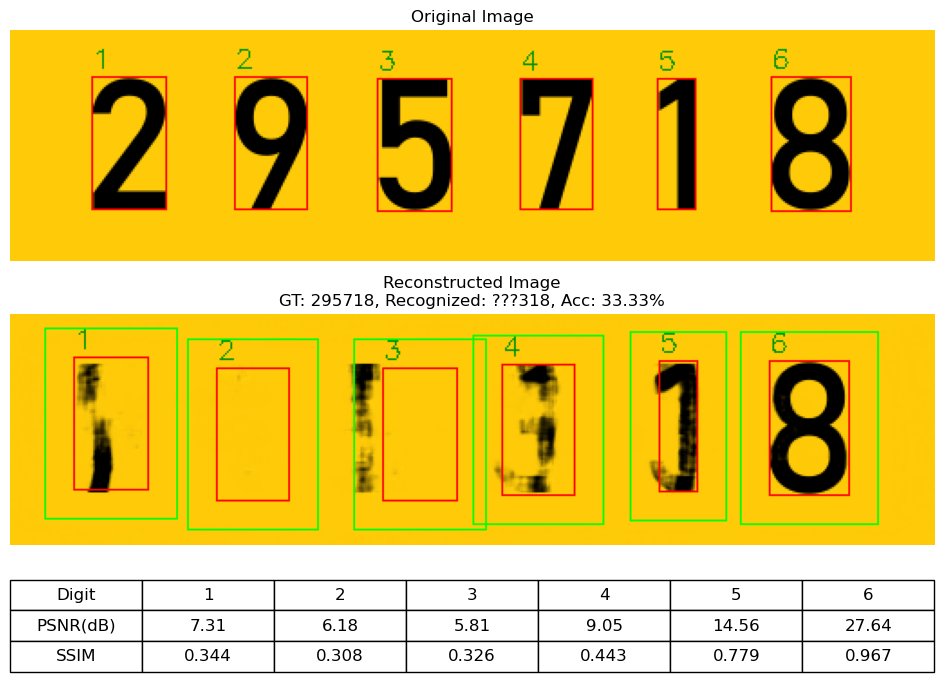

In [14]:

def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

to_tensor = transforms.ToTensor()

# Find metadata for the target alpha, beta
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]
found_file = None
for meta_file in metadata_files:
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)
    if metadata.get('alpha') == target_alpha and metadata.get('beta') == target_beta:
        found_file = {
            "metadata_file": meta_file,
            "index": metadata.get('idx'),
            "noise_level": metadata.get('noise_level'),
            "digit_bboxes": metadata.get('digit_bboxes'),
            "plate_number": metadata.get('plate_number')
        }
        break

if not found_file:
    print("Image with the specified alpha and beta not found.")
    exit()

print(f"Found metadata file: {found_file['metadata_file']}")
print(f"Alpha: {target_alpha}, Beta: {target_beta}")
print(f"Noise Level: {found_file['noise_level']:.2f}")
print(f"Plate Number: {found_file['plate_number']}")

original_bboxes = sorted(found_file['digit_bboxes'], key=lambda bbox: bbox[0])

original_image_path = os.path.join(data_dir, f"original_{found_file['index']}.png")
distorted_image_path = os.path.join(data_dir, f"distorted_{found_file['index']}.png")

original_img = to_tensor(Image.open(original_image_path).convert('RGB')).unsqueeze(0).to(device)
distorted_img = to_tensor(Image.open(distorted_image_path).convert('RGB')).unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_tensor = model(distorted_img)
    reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
reconstructed_np = reconstructed_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

# Align and update bboxes using template matching
def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    search_margin = 10

    for bbox in digit_bboxes:
        x, y, w, h = bbox

        # Extract original digit
        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Define search window in reconstructed
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Template matching
        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1

        updated_bboxes.append((best_x, best_y, w, h))

        # Compute PSNR and SSIM
        aligned_digit = reconstructed_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)

        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, original_bboxes)

# Convert reconstructed to BGR for visualization
reconstructed_show = (reconstructed_np * 255).astype(np.uint8)
reconstructed_show = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)
original_image_cv = cv2.imread(original_image_path)

# Draw original bounding boxes
for i, bbox in enumerate(original_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(original_image_cv, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

# Draw updated bounding boxes on reconstructed image
for i, bbox in enumerate(updated_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(reconstructed_show, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(reconstructed_show, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
reconstructed_image_rgb = cv2.cvtColor(reconstructed_show, cv2.COLOR_BGR2RGB)

# Tesseract single-digit OCR function
def ocr_single_digit(image_bgr, margin=5):
    """
    Recognize a single digit from a small cropped patch using Tesseract.
    Uses --psm 10 for single char and a whitelist of digits.
    """
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    # Binary threshold might help
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Tesseract config for single character digit recognition
    config = r'--oem 1 --psm 10 -c tessedit_char_whitelist=0123456789'

    text = pytesseract.image_to_string(thresh, config=config).strip()
    if len(text) == 1 and text.isdigit():
        return text
    # If Tesseract fails or returns something unexpected, return '?'
    return '?'

# Perform per-digit OCR using TMBB
plate_number_gt = found_file['plate_number']
recognized_digits = []

for i, bbox in enumerate(updated_bboxes):
    x, y, w, h = bbox
    # Add margin
    M = 16
    x1 = max(0, x - M)
    y1 = max(0, y - M)
    x2 = min(reconstructed_show.shape[1], x + w + M)
    y2 = min(reconstructed_show.shape[0], y + h + M)
    digit_patch = reconstructed_show[y1:y2, x1:x2]
    
    reconstructed_show = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)
    cv2.rectangle(reconstructed_show, (x1, y1), (x2, y2), (0, 255, 0), 1)
    reconstructed_image_rgb = cv2.cvtColor(reconstructed_show, cv2.COLOR_BGR2RGB)

    recognized_digit = ocr_single_digit(digit_patch)
    recognized_digits.append(recognized_digit)

recognized_text = "".join(recognized_digits)

# Compute accuracy
gt = plate_number_gt
correct_digits = sum(1 for a, b in zip(gt, recognized_text) if a == b)
accuracy = correct_digits / len(gt) if gt else 0.0

# Prepare table
table_data = [["Digit", "PSNR(dB)", "SSIM"]]
for i, (psnr_val, ssim_val) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
    table_data.append([str(i), f"{psnr_val:.2f}", f"{ssim_val:.3f}"])
transposed_table_data = list(zip(*table_data))

# Plotting
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(reconstructed_image_rgb)
plt.title(f'Reconstructed Image\nGT: {gt}, Recognized: {recognized_text}, Acc: {accuracy*100:.2f}%')
plt.axis('off')

table = plt.table(cellText=transposed_table_data,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, -0.55, 1, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.tight_layout()
plt.show()
